In [1]:
from qiskit import IBMQ, pulse, schedule
from qiskit.circuit import QuantumCircuit, Gate, Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from sympy import *
from sympy.physics.quantum import *

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
IBMQ.load_account() # load if no backend satisfies
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
qubit = 0
backend_config = backend.configuration()
dt = backend_config.dt  
backend_defaults = backend.defaults()

# The Matrix (1999)

In this section we look at how Hadamard gate is synthesized from elementary gates, namely $X_{\theta}^{(mn)}$ and $Z_{\phi}^{(mn)}$. The cannonical form of $H_3$ is 

\begin{align}
H_3 = \dfrac{1}{\sqrt{3}}\begin{pmatrix}
1 & 1 & 1 \\
1 & \omega & \omega^2 \\
1 & \omega^2 & \omega \end{pmatrix}
\end{align}

where $\omega = \exp[j(2\pi/3)]$. We also introduce two sets of elementary rotations in their respective computational subspaces. First is in the (01) subspace,

\begin{align}
X_{\theta}^{(01)} = \begin{pmatrix}
\cos\left(\dfrac{\theta}{2}\right) & -j\sin\left(\dfrac{\theta}{2}\right) & 0 \\
-j\sin\left(\dfrac{\theta}{2}\right) & \cos\left(\dfrac{\theta}{2}\right) & 0 \\
0 & 0 & 1 \end{pmatrix}\qquad\qquad
Z_{\phi}^{(01)} = \begin{pmatrix}
\exp\left(-j\dfrac{\phi}{2}\right) & 0 & 0 \\
0 & \exp\left(j\dfrac{\phi}{2}\right) & 0 \\
0 & 0 & 1 \end{pmatrix},
\end{align}

and secondly in the (12) subspace, 

\begin{align}
X_{\theta}^{(12)} = \begin{pmatrix}
1 & 0 & 0 \\
0 & \cos\left(\dfrac{\theta}{2}\right) & -j\sin\left(\dfrac{\theta}{2}\right) \\
0& -j\sin\left(\dfrac{\theta}{2}\right) & \cos\left(\dfrac{\theta}{2}\right) 
\end{pmatrix}\qquad\qquad
Z_{\phi}^{(12)} = \begin{pmatrix}
1 & 0 & 0 \\
0 & \exp\left(-j\dfrac{\phi}{2}\right) & 0 \\
0 & 0 & \exp\left(j\dfrac{\phi}{2}\right)
\end{pmatrix},
\end{align}

In [3]:
theta = Symbol('theta')
phi = Symbol('phi')
phi_6 = Symbol('\phi_6')
phi_5 = Symbol('\phi_5')
phi_4 = Symbol('\phi_4')
phi_3 = Symbol('\phi_3')
phi_2 = Symbol('\phi_2')
phi_1 = Symbol('\phi_1')
theta_3 = Symbol('\theta_3')
theta_2 = Symbol('\theta_2')
theta_1 = Symbol('\theta_1')

omega = exp(I*2*3.14159/3)

# |0> state
ground = Matrix([
        [1],
        [0],
        [0]
    ])

# Hadamard gate
def H3(omega):
    return Matrix([
        [1/sqrt(3), 1/sqrt(3), 1/sqrt(3)],
        [1/sqrt(3), 1/sqrt(3)*omega, 1/sqrt(3)*omega**2],
        [1/sqrt(3), 1/sqrt(3)*omega**2, 1/sqrt(3)*omega]
    ])

# Rotation along the X axis in (12) subspace
def X12(theta):
    return Matrix([
        [1, 0, 0],
        [0, cos(theta/2), -I*sin(theta/2)],
        [0, -I*sin(theta/2), cos(theta/2)]
    ])

# Rotation along the Z axis in (12) subspace
# Note that Z and P are just different representation of 
# the same effect /
def Z12(phi):
    return Matrix([
        [1, 0, 0],
        [0, exp(-I*phi/2), 0],
        [0, 0, exp(I*phi/2)]
    ])

def P2(phi):
    return Matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, exp(I*phi)]
    ])

# Rotation along the X axis in (01) subspace
def X01(theta):
    return Matrix([
        [cos(theta/2), -I*sin(theta/2), 0],
        [-I*sin(theta/2), cos(theta/2), 0],
        [0, 0, 1]
    ])

# Rotation along the Z axis in (01) subspace
def Z01(phi):
    return Matrix([
        [exp(-I*phi/2), 0, 0],
        [0, exp(I*phi/2), 0],
        [0, 0, 1]
    ])

def P0(phi):
    return Matrix([
        [exp(I*phi), 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

# Diagonal matrix
def diagonal(phi_6, phi_5, phi_4):
    return Matrix([
        [exp(I*phi_6), 0, 0],
        [0, exp(I*phi_5), 0],
        [0, 0, exp(I*phi_4)]
    ])

Our decomposition (see [here](https://github.com/ngdnhtien/randomized-benchmarking/blob/main/probing_clifford.ipynb)) is slightly different from that of Waterloo team. We both acknowledge the fact that any SU(3) gate can be written as 

\begin{align} 
U &= U_d(\phi_6, \phi_5, \phi_4)\cdot R_{\phi_3}^{(01)}(\theta_3) \cdot R_{\phi_2}^{(12)}(\theta_2) \cdot R_{\phi_1}^{(01)}(\theta_1)\\
&= U_d(\phi_6, \phi_5, \phi_4) \cdot P_{-\phi_3}^{0} \cdot X_{\theta_3}^{(01)} \cdot P_{\phi_3}^{0} \cdot P_{\phi_2}^{2} \cdot X_{\theta_2}^{(12)} \cdot P_{-\phi_2}^{2} \cdot P_{-\phi_1}^{0} \cdot X_{\theta_1}^{(01)} \cdot P_{\phi_1}^{0}\\
&= U_d(\phi_6,\phi_5,\phi_4)\cdot Z_{\phi_3}^{(01)} \cdot X_{\theta_3}^{(01)} \cdot Z_{-\phi_3}^{(01)} \cdot Z_{\phi_2}^{(12)} \cdot X_{\theta_2}^{(12)} \cdot Z_{-\phi_2}^{(12)} \cdot Z_{\phi_1}^{(01)} \cdot X_{\theta_1}^{(01)} \cdot Z_{-\phi_1}^{(01)}
\end{align}

The maths says that $\theta_1, \theta_2, \theta_3, \phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are $(1.5708,
 1.91063,
 1.5708,
 -2.61799,
 -2.61799,
 -1.0472,
 2.0944,
 -3.14159,
 -6.80678)$. So, for the Hadamard gate, we would like to observe on the schedule something like
 
 \begin{align}
H = U_d( -6.80678,-3.14159,2.0944)\cdot Z_{-1.0472}^{(01)} \cdot X_{1.5708}^{(01)} \cdot Z_{1.0472}^{(01)} \cdot Z_{-2.61799}^{(12)} \cdot X_{1.91063}^{(12)} \cdot Z_{2.61799}^{(12)} \cdot Z_{−2.61799}^{(01)} \cdot X_{1.5708}^{(01)} \cdot Z_{2.61799}^{(01)}\end{align}



In [4]:
R01_oneway = P0(phi)*X01(theta)*P0(-phi)
R01_theotherway = Z01(-phi)*X01(theta)*Z01(phi) 
R12_oneway = P2(phi)*X12(theta)*P2(-phi)
R12_theotherway = Z12(phi)*X12(theta)*Z12(-phi)

R12_oneway - R12_theotherway - R01_oneway + R01_theotherway

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [5]:
# M1 = P0(-phi)*X01(theta)*P0(phi)*P2(phi)*X12(theta)*P2(-phi)*P0(-phi)*X01(theta)*P0(phi) 
# M2 = Z01(phi)*X01(theta)*Z01(-phi)*Z12(phi)*X12(theta)*Z12(-phi)*Z01(phi)*X01(theta)*Z01(-phi)

M1 = P0(-phi)*X01(theta)*P0(phi)*P2(phi)*X12(theta)*P2(-phi)*P0(-phi)*X01(theta)*P0(phi)
M2 = Z01(phi)*X01(theta)*Z01(-phi)*Z12(phi)*X12(theta)*Z12(-phi)*Z01(phi)*X01(theta)*Z01(-phi)

M = M1 - M2

for i in range(9):
    M[i] = simplify(M[i])

M

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

Is this Hadamard? 

In [6]:
M = H3(omega) - diagonal(-6.806784170883084, -3.1415926536131353, 2.094395102400976)*Z01(-1.0471976392862354)*X01(1.5707957078968964)*Z01(1.0471976392862354)*Z12(-2.6179938780070557)*X12(1.9106338956261688)*Z12(2.6179938780070557)*Z01(-2.6179938779837135)*X01(1.5707957078968964)*Z01(2.6179938779837135)

for i in range(9):
    M[i] = simplify(M[i])
    
M

Matrix([
[                                                                                    -0.577350358528355 + sqrt(3)/3 + 4.64163270957885e-7*I, sqrt(3)/3 + 0.499999999999904*I*(-0.49999992369192 + 0.866025447840925*I) + 0.288674999999945*I*(0.866025403792219 + 0.499999999986524*I),                                            -0.577350225123859 + sqrt(3)/3 - 7.07050105184937e-17*I],
[sqrt(3)/3 + 0.499999999999904*I*(-0.499999923691919 + 0.866025447840925*I) + 0.288674999999945*I*(0.866025403792219 + 0.499999999986524*I),                                            0.288675134600027 - 0.499999690557736*I + sqrt(3)*(-0.499998467948436 + 0.866026288313015*I)/3, (0.866025403780548 - 0.500000000006738*I)*(sqrt(3)*exp(4.71238544227275*I) + 1.73205174733461*I)/3],
[                                                                                   -0.577350225123859 + sqrt(3)/3 - 7.07050105184937e-17*I,                                        (0.866025403780548 - 0.500000000006738*I)*(sqrt(3

It does not look like a matrix with zero-entry everywhere. What's wrong?

Correction: It does not look like a matrix with zero-entry everywhere, but it's a null matrix to a experimental extent. 

# Pulsating Pulses

In [9]:
f01 = 4925170000.0
f12 = 4581552617.648945

d12_duration = 544
d12_amplitude = 0.10879003883868105
d12_sigma = 40

d01_duration = 544
d01_sigma = 67
d01_amplitude = 0.07999888439750123

$X_\pi^{(01)}$ instructions

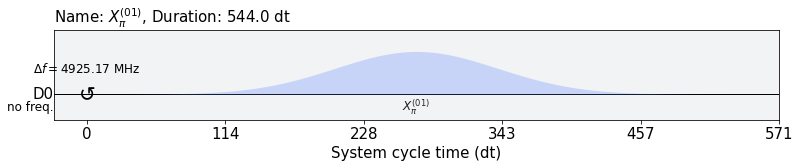

In [10]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=d01_duration,
                                  amp=d01_amplitude,
                                  sigma=d01_sigma,
                                  name=r'$X_{\pi}^{(01)}$'), drive_chan)

xpi01 = Gate('xp01', 1, [])
inst_xpi01.draw()

$X_\pi^{(12)}$ instructions

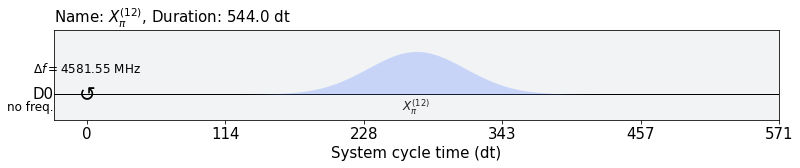

In [11]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as inst_xpi12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=d12_duration,
                                  amp=d12_amplitude,
                                  sigma=d12_sigma,
                                  name=r'$X_{\pi}^{(12)}$'), drive_chan)

xpi12 = Gate('xp12', 1, [])
inst_xpi12.draw()

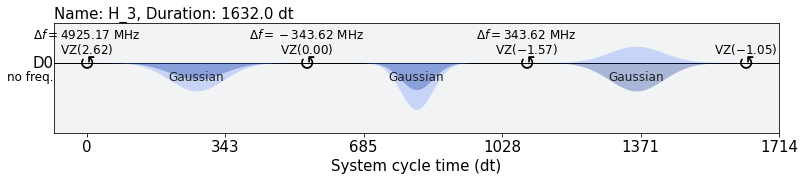

In [13]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'H_3') as Hadamard:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(-2.6179938779837135, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                 amp=(1.5707957078968964/np.pi)*d01_amplitude,
                                 sigma=d01_sigma), drive_chan)
    pulse.set_frequency(f12, drive_chan)
    with pulse.phase_offset(-2.6179938780070557, drive_chan):
        pulse.play(pulse.Gaussian(duration=d12_duration,
                                 amp=(1.91063/np.pi)*d12_amplitude,
                                 sigma=d12_sigma), drive_chan)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(-1.0471976392862354, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                 amp=(1.5707957078968964/np.pi)*d01_amplitude,
                                 sigma=d01_sigma), drive_chan)
Hadamard.draw()

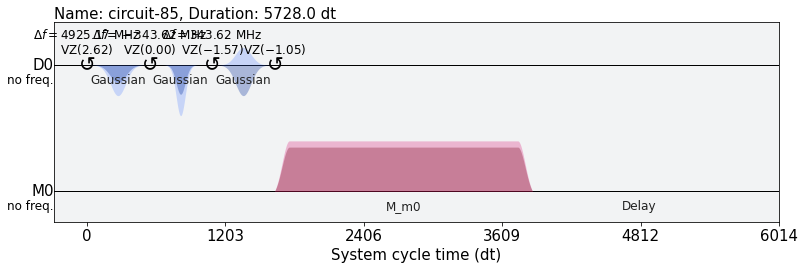

In [15]:
qc = QuantumCircuit(1,1)

H = Gate('Hadamard', 1, [])

qc.append(H, [0])
qc.measure(0,0)
qc.add_calibration(H, (0,), Hadamard, [])

sched = schedule(qc, backend)
sched.draw()

In [16]:
num_shots = 2**14

job = backend.run(qc, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [ ]:
num_shots = 2**14

job2 = backend.run(qc, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job2)